**Magnetostatic**

In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\mathbf{b} = \frac{\mu_0}{4\pi}  \int_{V}   \mathbf{M} \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\mathbf{M}$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\mathbf{b}$ and the magnetized object. Assuming a purely induced response, the strength of magnetization can be written as:

$$ \mathbf{M} = \mu_0 \kappa \mathbf{H}_0 $$
where $\kappa$ is the magnetic susceptibility, a unitless quantity describing the ability of matter to become magnetized in the direction of the Earth's field $\mathbf{H}_0$

As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \mathbf{b}^{TMI} =   \mathbf{\hat H}_0 \cdot\left( \mathbf{T} \cdot \mathbf{H}_0 \; \kappa \right) $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\mathbf{M}$ to the components of the field $\mathbf{b}$.
This is a simple linear system we can invert.

**Gravity**

The relation between density and the gravity field is well known, thanks to the classic work of Newton in 1686. Since we generally only measure the vertical component of the field, this relationship can be written as:
$$G(r)_z = \gamma \int_{V}   \rho(r) \left(\frac{z - z_0}{{|\vec r - \vec r_0|}^3}\right) \; dV $$
where $\rho$ is the anomalous density and $\gamma$ is the Newton's gravitational constant.
Once again, this integral can be evaluated analytically for simple prisms, giving rise to a linear system of equations relating a discrete Earth to the observed data:|
$$ \mathbf{d}_z =  \mathbf{G}_z \; \rho $$

In [3]:
%pylab inline 
import SimPEG.PF as PF
from SimPEG import Utils, Mesh, Maps
from SimPEG.Utils import io_utils

Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [4]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
import matplotlib.patches as patches

**Analytical Field**

We can first look at what the fields look like for simple susceptible and density anomalies.

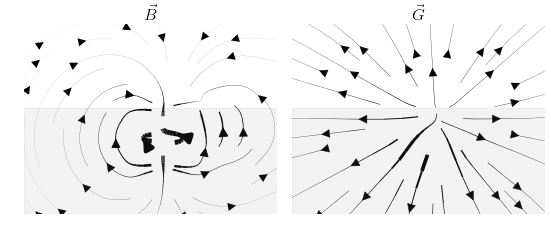

In [5]:
# Plot a dipole field for sketch
xmin, xmax = -5., 5.
zmin, zmax = -5., 5.
nc = 11
R = 1.
x0, y0, z0 = 0.5, 0.5, 0.5
chi = 1
G = 1.
Ho = np.asarray([[1,0,0],np.r_[1,0,0]])

# Compute MAG fields
x, y, z = np.meshgrid(np.linspace(xmin, xmax, nc), np.zeros(1), np.linspace(zmin, zmax, nc))
Bx1, By1, Bz1 = PF.MagAnalytics.MagSphereFreeSpace(x, y, z, R, x0, y0, z0, chi, Ho)
Bx2, By2, Bz2 = PF.MagAnalytics.MagSphereFreeSpace(x, y, z, R/2., x0+2., y0, z0+0.5, chi*2., Ho)

Bx = (Bx1+Bx2).reshape((nc,nc))
Bz = (Bz1+Bz2).reshape((nc,nc))
lBl = np.sqrt(Bx**2. + Bz**2.)

# Compute Gravity field
Gx1, Gz1 = G*(np.pi*R**2.)*np.r_[(x[:]-x0),(z[:]-z0)]/((x-x0+1e-1)**2.+(z-z0+1e-1)**2.)
Gx2, Gz2 = G*(2*np.pi*(R/2.)**2.)*np.r_[(x[:]-(x0+2.)),(z[:]-(z0+0.5))]/((x-x0+1e-1)**2.+(z-z0+1e-1)**2.)

Gx = (Gx1+Gx2).reshape((nc,nc))
Gz = (Gz1+Gz2).reshape((nc,nc))
lGl = np.sqrt(Gx**2. + Gz**2.)

# Plot vector field
fig = plt.figure(figsize = (8,4))
ax0 = plt.subplot(1,2,1)
lw = 5.*(lBl / lBl.max())

stp = streamplot(z[0,:,:], x[0,:,:], Bz, Bx,color='k', linewidth=lw, density=0.5,arrowsize=2)
# circle1= plt.Circle((x0,z0),R,color='b',fill=True, lw=3)
# ax0.add_artist(circle1)
# circle1= plt.Circle((x0+2.,z0+0.5),R/2.,color='r',fill=True, lw=3)
# ax0.add_artist(circle1)
ax0.add_patch(patches.Rectangle((xmin, zmin),10., 10./1.5, alpha=0.1,color='grey' ))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([xmin,xmax])
plt.ylim([zmin/2.,zmax])
plt.axis('off')
plt.tight_layout()
plt.rc('text', usetex=True)
plt.title(r'$\vec B$')
ax0 = plt.subplot(1,2,2)
lw = 5.*(lGl / lGl.max())

stp = streamplot(z[0,:,:], x[0,:,:], Gz, Gx,color='k', linewidth=lw, density=0.5,arrowsize=2)
# circle1= plt.Circle((x0,z0),R,color='b',fill=True, lw=3)
# ax0.add_artist(circle1)
# circle1= plt.Circle((x0+2.,z0+0.5),R/2.,color='r',fill=True, lw=3)
# ax0.add_artist(circle1)
ax0.add_patch(patches.Rectangle((xmin, zmin),10., 10./1.5, alpha=0.1,color='grey' ))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([xmin,xmax])
plt.ylim([zmin/2.,zmax])
plt.title(r'$\vec G$')
plt.axis('off')
fig.savefig('PF_Sketch.png',dpi = 150)

**Plots for TKC**

If the model files are not already in the directory, you need to run the inversion notebook "Magnetic over TKC.pync"

In [114]:
import os

model_dir = "Models\\"
# Load the mesh, model and data
mesh = Mesh.TensorMesh.readUBC(model_dir+"PF_mesh_UTM.msh")

# Load models
m_lp = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"SimPEG_MAG_lplq.sus")
m_l2 = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"SimPEG_MAG_l2l2.sus")
m_true = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"Synthetic_mag.sus")
# mesh.writeVTK('MAG_model.vtr',{'Sus':m_true})

# m_lp = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"SimPEG_GRAV_lplq.den")
# m_l2 = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"SimPEG_GRAV_l2l2.den")
# m_true = Mesh.TensorMesh.readModelUBC(mesh,model_dir+"Synthetic_Grav.den")


airc = m_true == -1

m_lp[airc] = np.nan
m_l2[airc] = np.nan
m_true[airc] = np.nan

# Load data
temp = PF.MagneticsDriver.MagneticsDriver_Inv()
temp.basePath = os.getcwd() + os.path.sep
survey = temp.readMagneticsObservations(model_dir+"MAG_Synthetic_data.obs")


# temp = PF.GravityDriver.GravityDriver_Inv()
# temp.basePath = os.getcwd() + os.path.sep
# survey = temp.readGravityObservations(model_dir+"GRAV_Synthetic_data.obs")

# survey.srcField.rxList[0].locs[:,0] = survey.srcField.rxList[0].locs[:,0] - 557300.
# survey.srcField.rxList[0].locs[:,1] = survey.srcField.rxList[0].locs[:,1] - 7133600.

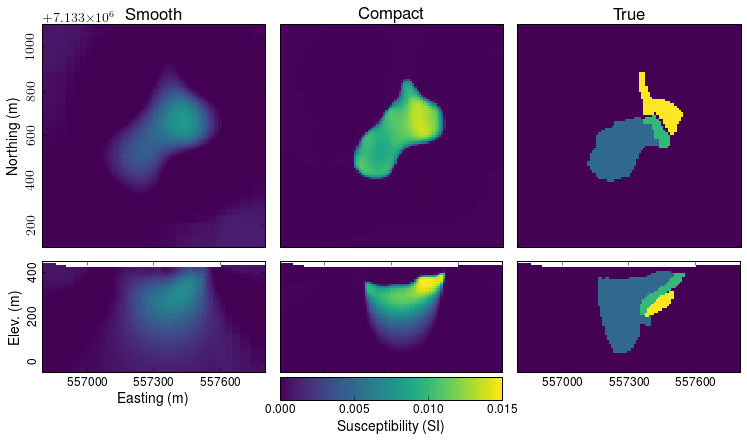

In [116]:

fig = plt.figure(figsize(11, 8))
vmin, vmax = 0.0, 0.015
xmin, xmax = -500 + 557300, 500 + 557300
ymin, ymax = -500 + 7133600, 500 + 7133600
zmin, zmax = -500 + 450, 0 + 450
indz = 46
indx = 38

# Axis label
x = np.linspace(xmin+200, xmax-200,3)
y = np.linspace(zmin+50, zmax-50,3)

ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
dat = mesh.plotSlice(m_l2, ax = ax1, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('Smooth')
ax1.xaxis.set_visible(False)
xlim(xmin, xmax)
ylim(ymin, ymax)    
ylabel('Northing (m)')
labels = ax1.get_yticklabels()
plt.setp(labels, rotation=90)

# ax2 = plt.subplot(2,2,3)
pos =  ax1.get_position()
ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_l2, ax = ax2, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('')
xlim(xmin, xmax)
ylim(zmin, zmax) 
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=12)
xlabel('Easting (m)')
ylabel('Elev. (m)')
ax2.set_yticks(map(int, y))
ax2.set_yticklabels(map(str, map(int, y)),size=12)
labels = ax2.get_yticklabels()
plt.setp(labels, rotation=90)

## Add compact model
ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
dat = mesh.plotSlice(m_lp, ax = ax3, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('Compact')
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
xlim(xmin, xmax)
ylim(ymin, ymax)    

ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_lp, ax = ax4, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
ax4.yaxis.set_visible(False)
plt.title('')
xlim(xmin, xmax)
ylim(zmin, zmax) 
ax4.set_xticks(map(int, x))
ax4.set_xticklabels(map(str, map(int, x)),size=12)
xlabel('')
# ylabel('Elev. (m)')

## Add True model 
ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
dat = mesh.plotSlice(m_true, ax = ax5, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
plt.title('True')
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)
xlim(xmin, xmax)
ylim(ymin, ymax)    

ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# ax2.yaxis.set_visible(False)
# ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

dat = mesh.plotSlice(m_true, ax = ax6, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
plt.gca().set_aspect('equal')
ax6.yaxis.set_visible(False)
plt.title('')
xlim(xmin, xmax)
ylim(zmin, zmax) 
ax6.set_xticks(map(int, x))
ax6.set_xticklabels(map(str, map(int, x)),size=12)
xlabel('')
# ylabel('Elev. (m)')

pos =  ax4.get_position()
cbarax = fig.add_axes([pos.x0 , pos.y0+0.05 ,  pos.width, pos.height*0.1])  ## the parameters are the specified position you set
cb = fig.colorbar(dat[0],cax=cbarax, orientation="horizontal", ax = ax4, ticks=np.linspace(vmin,vmax, 4),format='%.3f')
cbarax.tick_params(labelsize=12)
# cb.ax.xaxis.set_label_position('top')
cb.set_label("Susceptibility (SI)",size=14)
fig.savefig('MAG_RecModel.png',dpi = 200)

# cb.set_label("Density (d/cc)",size=14)
# fig.savefig('GRAV_RecModel.png',dpi = 200)

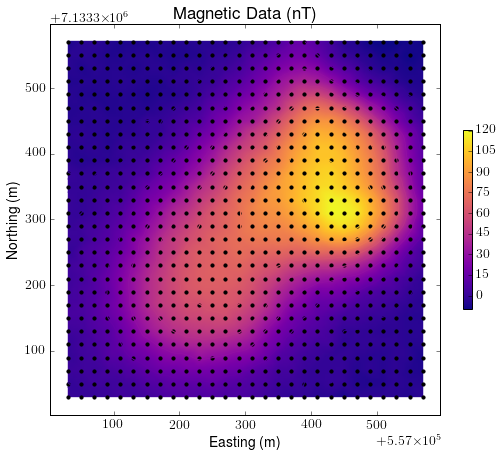

In [6]:
# Plot some fields
fig = plt.figure(figsize=(8,7))

fig = PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs,survey.dobs, fig=fig)
title('Magnetic Data (nT)')
xlabel('Easting (m)')
ylabel('Northing (m)')
fig.savefig('MAG_Data.png',dpi = 200)

# fig = PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs,survey.dobs, fig=fig)
# title('Gravity Anomaly (mGal)')
# xlabel('Easting (m)')
# ylabel('Northing (m)')
# fig.savefig('GRAV_Data.png',dpi = 200)

In [8]:
# Run simulation to get fields through the pipe
# We create a synthetic survey with observations in cell center.

def genFields_Plane(xlim,ylim,zplane,normal='Z',surveyType = 'GRAV'):
    
    if normal=='Z':
        x, y = np.linspace(xlim[0],xlim[1],11), np.linspace(ylim[0],ylim[1],11)
        X, Y = np.meshgrid(x, y)
        Z = np.ones(X.shape)*zplane
        
    elif normal == 'X':
        
        x, y = np.linspace(xlim[0],xlim[1],11), np.linspace(ylim[0],ylim[1],11)
        Y, Z = np.meshgrid(x, y)
        X = np.ones(Y.shape)*zplane

    else: 

        x, y = np.linspace(xlim[0],xlim[1],11), np.linspace(ylim[0],ylim[1],11)
        X, Z = np.meshgrid(x, y)
        Y = np.ones(X.shape)*zplane
        
    rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
    

    
    if surveyType == "MAG":
        rxLoc = PF.BaseMag.RxObs(rxLoc)

        srcField = PF.BaseMag.SrcField([rxLoc])
        srcField.param = survey.srcField.param
        section = PF.BaseMag.LinearSurvey(srcField)
        
        m = m_true
        m[airc] = 0.
        actv = m > 1e-4
        m = m[actv]

        # Creat reduced identity map
        idenMap = Maps.IdentityMap(nP = int(np.sum(actv)))
        # Create the forward model operator
        prob = PF.Magnetics.Problem3D_Integral(mesh, forwardOnly=True, rtype = 'xyz', actInd = actv, mapping = idenMap)

    elif surveyType == "GRAV":
        
        rxLoc = PF.BaseGrav.RxObs(rxLoc)

        srcField = PF.BaseGrav.SrcField([rxLoc])
        section = PF.BaseGrav.LinearSurvey(srcField)
        
        m = m_true
        m[airc] = 0.
        actv = np.abs(m) != 0.
        m = m[actv]

        # Creat reduced identity map
        idenMap = Maps.IdentityMap(nP = int(np.sum(actv)))
        
        # Create the forward model operator
        prob = PF.Gravity.GravityIntegral(mesh, forwardOnly=True, rtype = 'xyz', actInd = actv, mapping = idenMap)

        
    # Pair the survey and problem
    section.pair(prob)

    # Compute fields
    d = prob.fields(m)
    
    return d, x, y


Begin calculation forward calculations... G not stored: 
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

Begin calculation forward calculations... G not stored: 
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



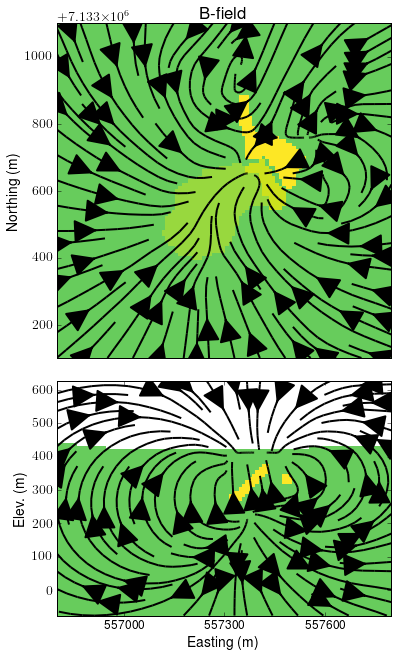

In [10]:

vmin, vmax = -0.05, 0.015
fig = plt.figure(figsize(6,9))
indx = 55

stype = "MAG"

# Reshape the fields and plot
fld, x ,y = genFields_Plane((xmin,xmax),(ymin,ymax),mesh.vectorCCz[indz],normal='Z', surveyType=stype)

ndata = len(x)*len(y)
fld_x = fld[:ndata].reshape((len(y),len(x)))
fld_y = fld[ndata:2*ndata].reshape((len(y),len(x)))
fld_z = -fld[2*ndata:].reshape((len(y),len(x)))

fld_B = np.sqrt(fld_x**2 + fld_y**2+ fld_z**2)
padx = 4
m_true[airc] = np.nan


ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0+0.05, pos.y0+.2,  pos.width, pos.height])
dat = mesh.plotSlice(m_true, ax = ax1, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])

plt.gca().set_aspect('equal')
plt.title('B-field')
strp = ax1.streamplot(x, y, fld_x, fld_y,color='k',density=1, linewidth = 2., arrowsize = 5)
ax1.xaxis.set_visible(False)
xlim(xmin, xmax)
ylim(ymin, ymax)    
xlabel('Easting (m)')
ylabel('Northing (m)')

# Reshape the fields and plot
fld, x ,y = genFields_Plane((xmin,xmax),(zmin,zmax+200),mesh.vectorCCy[indx],normal='Y', surveyType=stype)

ndata = len(x)*len(y)
fld_x = fld[:ndata].reshape((len(y),len(x)))
fld_y = fld[ndata:2*ndata].reshape((len(y),len(x)))
fld_z = -fld[2*ndata:].reshape((len(y),len(x)))

fld_B = np.sqrt(fld_x**2 + fld_y**2+ fld_z**2)
padx = 4
m_true[airc] = np.nan


pos =  ax1.get_position()
ax2 = fig.add_axes([pos.x0, pos.y0 - 0.475,  pos.width, pos.height])
dat = mesh.plotSlice(m_true, ax = ax2, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])

plt.gca().set_aspect('equal')
plt.title('')
strp = ax2.streamplot(x, y, fld_x, fld_z,color='k',density=1, linewidth = 2., arrowsize = 5.)
# ax2.xaxis.set_visible(False)
xlim(xmin, xmax)
ylim(zmin, zmax+200)    
# Axis label
x = np.linspace(xmin+200, xmax-200,3)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=12)
xlabel('Easting (m)')
ylabel('Elev. (m)')

fig.savefig('GRAV_VectorField.png',dpi = 300)

In [ ]:
print ndata

In [ ]:
print survey.srcField.param
